In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg


In [2]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

LEARNING_RATE = 5e-5
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS_IMG = 3  
NOISE_DIM = 100
NUM_EPOCHS = 40
FEATURES_DISC = 64 
FEATURES_GEN = 64 
critic_iterations = 5
lambda_GP = 10


Device: cuda


In [3]:
dataset = datasets.CIFAR10(
    root="Desktop/dataset/CIFAR10data", 
    download=True,
    transform=transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])
)

dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2
)


Files already downloaded and verified


In [4]:
import os
if not os.path.isdir('Desktop/Results'):
    os.mkdir('Desktop/Results')


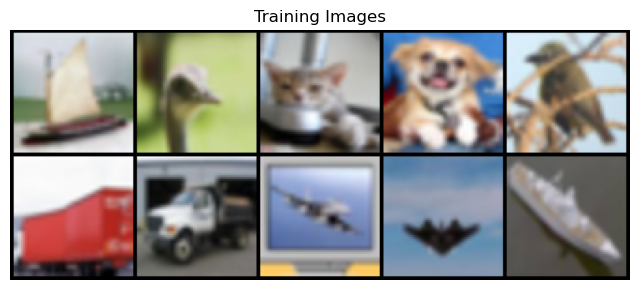

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')

# Convert the images into a grid and display them
img_grid = utils.make_grid(real_batch[0].to(device)[:10], nrow=5, padding=2, normalize=True)
plt.imshow(np.transpose(img_grid.cpu(), (1, 2, 0)))

# Save the figure as a .jpeg image
plt.savefig(
    'Desktop/Results/WGANGP_RealImg.jpg',
    format='jpeg',
    dpi=100,
    bbox_inches='tight'
)


In [6]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super().__init__()
        self.disc = nn.Sequential(
            # Input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # Applying _block with increasing feature sizes
            self.Dnet(features_d, features_d * 2, kernel_size=4, stride=2, padding=1),  # out=128
            self.Dnet(features_d * 2, features_d * 4, kernel_size=4, stride=2, padding=1),  # out=256
            self.Dnet(features_d * 4, features_d * 8, kernel_size=4, stride=2, padding=1),  # out=512
            # Final Conv2d to reduce the output to 1x1 after processing through all _block layers
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


In [7]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super().__init__()
        self.net = nn.Sequential(
            # Generator network blocks
            self.Gnet(channels_noise, features_g * 8, kernel_size=4, stride=1, padding=0),  # Output: 512 x 4 x 4
            self.Gnet(features_g * 8, features_g * 4, kernel_size=4, stride=2, padding=1),  # Output: 256 x 8 x 8
            self.Gnet(features_g * 4, features_g * 2, kernel_size=4, stride=2, padding=1),  # Output: 128 x 16 x 16
            self.Gnet(features_g * 2, features_g, kernel_size=4, stride=2, padding=1),      # Output: 64 x 32 x 32
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1),  # Final output
            nn.Tanh()  # Output size: (n_channels) x 64 x 64
        )

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


In [8]:
def initialize_weights(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(module.weight.data, mean=0.0, std=0.02)


In [9]:
def GP(critic, real, fake):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand(BATCH_SIZE, 1, 1, 1).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)
    mixed_scores = critic(interpolated_images)

    # Compute the gradient of the scores w.r.t. interpolated images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

    return gradient_penalty


In [10]:
import os
if not os.path.isdir('Desktop/Models'):
    os.mkdir('Desktop/Models')


In [11]:
def save_model(model_type):
    if model_type == 'gen':
        print("=> Saving Generator model!!")
        torch.save(model, "Desktop/Models/CIFAR_wganGP_GENERATOR.pth.tar")
    elif model_type == 'disc':
        print("=> Saving Discriminator model!!")
        torch.save(model, "Desktop/Models/CIFAR_wganGP_DIS.pth.tar")

def load_model(gen, disc):
    print("=> Loading models!!")
    gen = torch.load("Desktop/Models/CIFAR_wganGP_GENERATOR.pth.tar")
    disc = torch.load("Desktop/Models/CIFAR_wganGP_DIS.pth.tar")


In [12]:
# Initialize the Generator and Discriminator models
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

# Initialize weights for both models
initialize_weights(gen)
initialize_weights(disc)

# Define optimizers for Generator and Discriminator using RMSprop
optimGenerator = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
optimDiscriminator = optim.RMSprop(disc.parameters(), lr=LEARNING_RATE)

# Create a fixed noise tensor for generating consistent outputs
fixed_noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)

# Initialize the training step counter
step = 0


In [13]:
gen.train(mode=True), disc.train(mode=True)


(Generator(
   (net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): ConvTr

In [14]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network for extracting feature maps"""
    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {
        64: 0,    # Features after the first max pooling layer
        192: 1,   # Features after the second max pooling layer
        768: 2,   # Features before the auxiliary classifier
        2048: 3   # Features after the final average pooling
    }

    def __init__(self, output_blocks=[DEFAULT_BLOCK_INDEX], resize_input=True,
                 normalize_input=True, requires_grad=False):
        super().__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, 'The last output block index can be at most 3'

        self.blocks = nn.ModuleList()

        # Load pretrained InceptionV3 model
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to auxiliary classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: auxiliary classifier to final average pooling
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        # Set requires_grad based on the flag
        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        output = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Normalize the input to range [-1, 1]

        # Forward pass through the selected blocks
        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                output.append(x)

            if idx == self.last_needed_block:
                break

        return output


# Initialize model with a specific block index
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx]).cuda()


def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()
    activations = np.empty((len(images), dims))

    # Prepare the batch for processing
    batch = images.cuda() if cuda else images
    pred = model(batch)[0]
    
    # Ensure the feature map has a size of 1x1
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    # Reshape the activations and return the mean and covariance
    activations = pred.cpu().data.numpy().reshape(pred.size(0), -1)
    mean = np.mean(activations, axis=0)
    covariance = np.cov(activations, rowvar=False)
    return mean, covariance


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1, mu2 = np.atleast_1d(mu1), np.atleast_1d(mu2)
    sigma1, sigma2 = np.atleast_2d(sigma1), np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, 'Mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, 'Covariance matrices have different dimensions'

    diff = mu1 - mu2

    # Calculate the covariance mean
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        print(f'FID calculation produces singular product; adding {eps} to covariance matrices')
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            raise ValueError(f'Imaginary component detected: {np.max(np.abs(covmean.imag))}')
        covmean = covmean.real

    trace_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * trace_covmean)


def calculate_fretchet(images_real, images_fake, model):
    mu_1, std_1 = calculate_activation_statistics(images_real, model, cuda=True)
    mu_2, std_2 = calculate_activation_statistics(images_fake, model, cuda=True)
    
    # Compute the Frechet Inception Distance (FID)
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value


/home/vmunaga/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vmunaga/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# Initialize loss and tracking lists
GenLoss = []
DiscLoss = []
DiscLossP = []
img_list = []
iters = 0
FID_list = []

print("!!Training Started!!")
# Start timing
time_start = time.time()

# Training loop for NUM_EPOCHS
for epoch in range(NUM_EPOCHS):
    epoch += 1
    
    for batch_idx, data in enumerate(dataloader, 0):
        # Get real images from the current batch
        real = data[0].to(device)
        batch_size = real.shape[0]

        # Train the Critic (Discriminator): maximize E[critic(real)] - E[critic(fake)]
        for _ in range(critic_iterations):
            noise = torch.randn(batch_size, NOISE_DIM, 1, 1).to(device)
            fake = gen(noise)  # Generate fake images

            # Get the critic's evaluation of real and fake images
            critic_real = disc(real).reshape(-1)
            critic_fake = disc(fake).reshape(-1)

            # Compute gradient penalty
            gp = GP(disc, real, fake)

            # Compute the critic loss
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + (lambda_GP * gp)

            # Zero gradients, backprop, and update the critic
            disc.zero_grad()
            loss_critic.backward(retain_graph=True)
            optimDiscriminator.step()

        # Train the Generator: maximize E[critic(gen_fake)] (minimize -E[critic(gen_fake)])
        output = disc(fake).reshape(-1)
        loss_gen = -torch.mean(output)

        # Zero gradients, backprop, and update the generator
        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()

        # Track and print the losses periodically
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_critic.detach().cpu())

        # Check the progress of the generator by saving its output at regular intervals
        if iters % 500 == 0 or (epoch == NUM_EPOCHS and batch_idx == len(dataloader) - 1):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
        
        iters += 1
        
    # Calculate Frechet Inception Distance (FID) for the current epoch
    fretchet_dist = calculate_fretchet(real, fake, model)
    FID_list.append(fretchet_dist)

    # Print the losses and FID score for the current epoch
    print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
            Loss Discriminator: {loss_critic:.3f}, Loss Generator: {loss_gen:.3f}, FID Score: {fretchet_dist:.3f}", end="\r", flush=True)

    # Save generated images at the end of each epoch
    labels = torch.arange(0, 10, dtype=torch.long, device=device)
    noise = torch.randn(10, 100, device=device)
    images = gen(fixed_noise)

    # Create directories for saving images if they don't exist
    os.makedirs('Desktop/Results/WGANGP_FAKE', exist_ok=True)
    os.makedirs('Desktop/Results/WGANGP_REAL', exist_ok=True)

    # Save generated images
    utils.save_image(images.detach(), f'Desktop/Results/WGANGP_FAKE/WGANGP_epoch_{epoch:03d}.png', normalize=True)

    # Save real images from the batch
    real = data[0].to(device)
    utils.save_image(real.detach(), f'Desktop/Results/WGANGP_REAL/WGANGP_epoch_{epoch:03d}.png', normalize=True)

# End timing and print the elapsed time
time_end = time.time()
print(f'\n\nElapsed time: {time_end - time_start:.2f} s.')

# Optionally save the models
# save_model(gen)
# save_model(disc)


!!Training Started!!
Epoch [40/40] Batch 1562/1563             Loss Discriminator: -11.586, Loss Generator: 235.056, FID Score: 289.410

Elapsed time: 4340.45 s.


In [17]:
os.makedirs('Desktop/Results/Loss_Data', exist_ok=True)


In [18]:
# Save generator and discriminator loss data to files
np.save('Desktop/Results/Loss_Data/WGANGP_GLoss.npy', GenLoss)
np.save('Desktop/Results/Loss_Data/WGANGP_DLoss.npy', DiscLoss)

# Load generator and discriminator loss data from files
GenLoss = np.load('Desktop/Results/Loss_Data/WGANGP_GLoss.npy')
DiscLoss = np.load('Desktop/Results/Loss_Data/WGANGP_DLoss.npy')


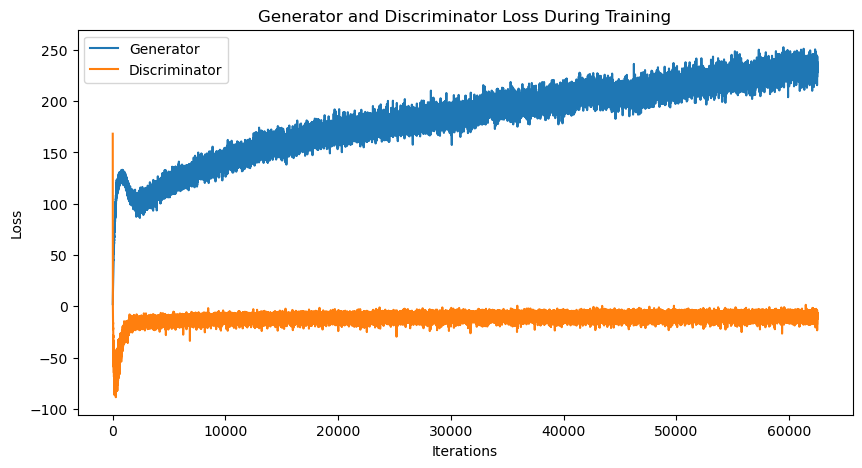

In [19]:
# Set up the plot with specified figure size and title
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")

# Plot generator and discriminator loss
plt.plot(GenLoss, label="Generator")
plt.plot(DiscLoss, label="Discriminator")

# Label the axes
plt.xlabel("Iterations")
plt.ylabel("Loss")

# Add legend to the plot
plt.legend()

# Save the plot as a PDF file
plt.savefig('Desktop/Results/Loss.pdf', format='pdf', dpi=100, bbox_inches='tight')

# Display the plot
plt.show()


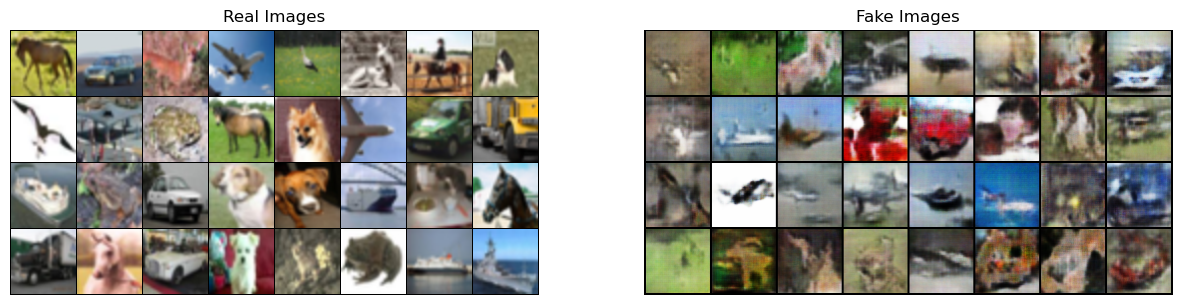

In [20]:
# Get a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Set up the figure with a specified size
plt.figure(figsize=(15, 15))

# Display real images
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(), (1, 2, 0)))

# Display fake images
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))

# Save the figure as a PDF file
plt.savefig('Desktop/Results/WGANGP_BEST_FAKE_32.pdf', format='pdf', dpi=100, bbox_inches='tight')

# Show the figure
plt.show()


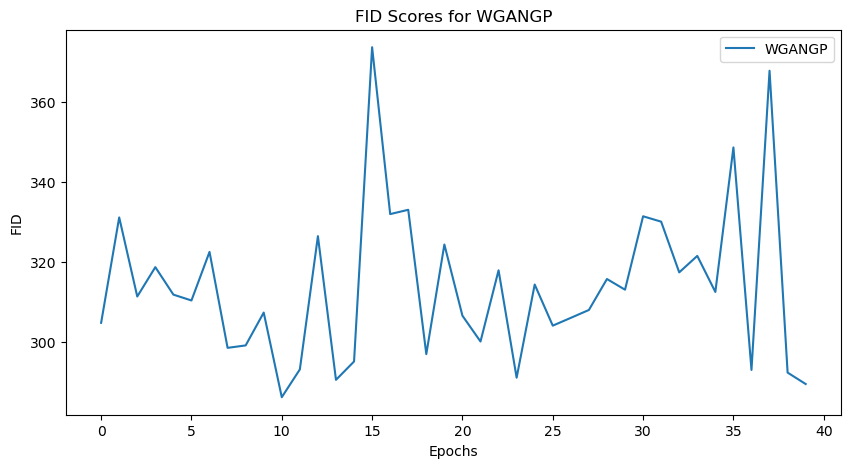

In [21]:
# Create a figure with a specified size
plt.figure(figsize=(10, 5))

# Add a title to the plot
plt.title("FID Scores for WGANGP")

# Plot the FID scores
plt.plot(FID_list, label="WGANGP")

# Label the axes
plt.xlabel("Epochs")
plt.ylabel("FID")

# Add a legend to the plot
plt.legend()

# Save the plot as a PDF file
plt.savefig('Desktop/Results/FID.pdf', format='pdf', bbox_inches='tight')

# Display the plot
plt.show()


In [22]:
# Create the directory for saving FID scores if it doesn't already exist
if not os.path.exists('Desktop/Results/FID_score'):
    os.makedirs('Desktop/Results/FID_score')

# Save the FID scores to a file
np.save('Desktop/Results/FID_score/WGANGP_FID', FID_list)
